In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import cv2
import time


training_path = "fruits-360/Training"
test_path = "fruits-360/Test"

try:
    STATS = np.load("stats.npy", allow_pickle=True)
except FileNotFoundError as fnf:
    print("Not found stats file.")
    STATS = []

# Parameters    
GRAY_SCALE = False
FRUITS = os.listdir(training_path)
random.shuffle(FRUITS)

# FRUITS = FRUITS[:15]

model_name = f"fruits-{len(FRUITS)}-AllFruits-{time.time():10.0f}"


tensorboard = TensorBoard(log_dir=f'logs/{model_name}')

Not found stats file.


In [2]:
class BatchGen:
    def __init__(self, dir_path, batch_size=100):
        self.dir_path = dir_path
        self.batch_size =  batch_size
        self.all_paths, self.all_labels = self.get_all_list()
        self.len = math.ceil(len(self.all_paths) / batch_size)
        
        print(f"Generator: {dir_path} has: {self.len} batches")
    
    def __len__(self):
        return self.len
    
    def _get_batch(self, paths, labels, batch_size=100):
        batch_x = []
        batch_y = []

        for pat, lab in zip(paths, labels):
    #         print(lab, pat)
            try:
                img = self.preprocess_img(pat)
            except FileNotFoundError:
                continue

            batch_x.append(img)
            batch_y.append(lab)

            if len(batch_x) >= batch_size:
                batch_x = np.array(batch_x)
                batch_y = np.array(batch_y)

                yield batch_x, batch_y            
                batch_x = []
                batch_y = []

        if len(batch_x) > 0:
            batch_x = np.array(batch_x)
            batch_y = np.array(batch_y)
            yield batch_x, batch_y


    def get_all_list(self):
        directory_path = self.dir_path
        img_paths = []
        labels = []


        for fruit_name in FRUITS:
            class_num = FRUITS.index(fruit_name)  # int labels        
            path = os.path.join(directory_path, fruit_name)

            for img in os.listdir(path):        
                img_path = os.path.join(path, img)    
                img_paths.append(img_path)
                labels.append(class_num)
        
        return img_paths, labels
    
    def shuffle(self):
        bag = [*zip(self.all_paths, self.all_labels)]
        random.shuffle(bag)
        self.all_paths, self.all_labels = zip(*bag)
        
    def preprocess_img(self, img_path):
        if GRAY_SCALE:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        else:
            image = cv2.imread(img_path)
            image = image[:, :, [2, 1, 0]]  # bgr -> rgb

        image = image / 255.0
        image = np.array(image)

        return image   
    
    def get_one_batch(self):
        x, Y = next(self.get_all_batches())
        yield x, Y
        
    def get_all_batches(self):
        self.shuffle()
        for x, Y in self._get_batch(self.all_paths,
                                    self.all_labels,
                                    batch_size=self.batch_size):
            yield x, Y




In [3]:
class AfterTwoEpochStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
#         super(AfterTwoEpochStop, self).__init__()
        self.threshold = threshold
        self.checked = False
        print("Init")

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]        
        if val_acc >= self.threshold:
            if self.checked:
                self.model.stop_training = True
            else:
                self.checked = True
        else:
            self.checked = False

stop = AfterTwoEpochStop(0.98)                

Init


In [4]:
# Limit gpu memory usage
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.compat.v1.Session(config=config)

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Activation, Dropout

pic_shape = (100, 100, 3,)
label_count = len(FRUITS)


# Input
model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=pic_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
#     Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dense(label_count, activation='softmax')    
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [6]:
train_gen = BatchGen(training_path, 50)
test_gen = BatchGen(test_path, 50)

history = model.fit(x=train_gen.get_all_batches(), 
                    validation_data=test_gen.get_all_batches(),
                    epochs=100,
                    shuffle=False,
                    steps_per_epoch=1,
                    validation_steps=1,
                    workers=1,
                    callbacks=[tensorboard, stop])

Generator: fruits-360/Training has: 4285 batches
Generator: fruits-360/Test has: 1439 batches
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 4.4861 - accuracy: 0.0000e+00 - val_loss: 4.8499 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 323ms/step - loss: 4.6133 - accuracy: 0.0000e+00 - val_loss: 4.5800 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 309ms/step - loss: 4.2729 - accuracy: 0.1000 - val_loss: 4.2642 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 306ms/step - loss: 4.7004 - accuracy: 0.0000e+00 - val_loss: 4.4632 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 308ms/step - loss: 4.4935 - accuracy: 0.0000e+00 - val_loss: 4.5125 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 303ms/step - loss: 4.548

Epoch 55/100
1/1 [==============================] - 0s 305ms/step - loss: 4.4334 - accuracy: 0.0000e+00 - val_loss: 4.2113 - val_accuracy: 0.1000
Epoch 56/100
1/1 [==============================] - 0s 311ms/step - loss: 4.1678 - accuracy: 0.2000 - val_loss: 4.2364 - val_accuracy: 0.2000
Epoch 57/100
1/1 [==============================] - 0s 322ms/step - loss: 4.2181 - accuracy: 0.0000e+00 - val_loss: 4.1325 - val_accuracy: 0.0000e+00
Epoch 58/100
1/1 [==============================] - 0s 295ms/step - loss: 4.2335 - accuracy: 0.0000e+00 - val_loss: 4.2205 - val_accuracy: 0.1000
Epoch 59/100
1/1 [==============================] - 0s 317ms/step - loss: 4.2512 - accuracy: 0.0000e+00 - val_loss: 3.9705 - val_accuracy: 0.1000
Epoch 60/100
1/1 [==============================] - 0s 300ms/step - loss: 4.0286 - accuracy: 0.2000 - val_loss: 4.2208 - val_accuracy: 0.1000
Epoch 61/100
1/1 [==============================] - 0s 312ms/step - loss: 3.8891 - accuracy: 0.1000 - val_loss: 4.5481 - val_acc

In [7]:
loss = history.history['loss']
accuracy = history.history['accuracy']


val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print(f"Test Accuracy: {val_accuracy[-1]:>2.4f}")
print(f"Test loss: {val_loss[-1]:>2.4f}")

Test Accuracy: 0.1000
Test loss: 3.8952


In [11]:
test_gen = BatchGen(test_path, 100)
X_test, y_test = next(test_gen.get_all_batches())
predictions = model.predict(X_test[:30])

Generator: fruits-360/Test has: 144 batches


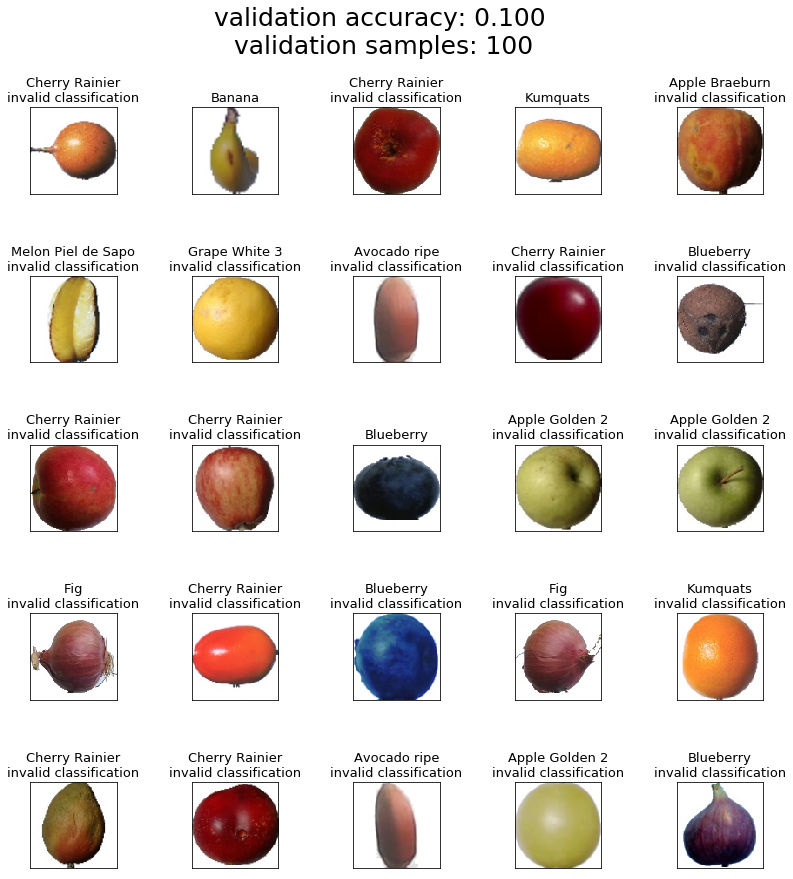

In [12]:
fig = plt.figure(figsize=(14, 14))
for x in range(1,26):
    class_num = np.argmax(predictions[x])
    valid = y_test[x] == class_num
    ax = fig.add_subplot(5, 5, x)
    
    image = np.array(X_test[x], dtype=float)
    ax.imshow(image)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    title = FRUITS[class_num] + ("\ninvalid classification" if not valid else "")
    ax.set_title(title, size=13)

last_val_accuracy = val_accuracy[-1]
    
fig.subplots_adjust(hspace=0.95)
fig.suptitle(f"validation accuracy: {last_val_accuracy:>2.3f} \nvalidation samples: {len(X_test)}", size=25)
fig.savefig(f"{model_name}-validation_example.png")
# fig.show()

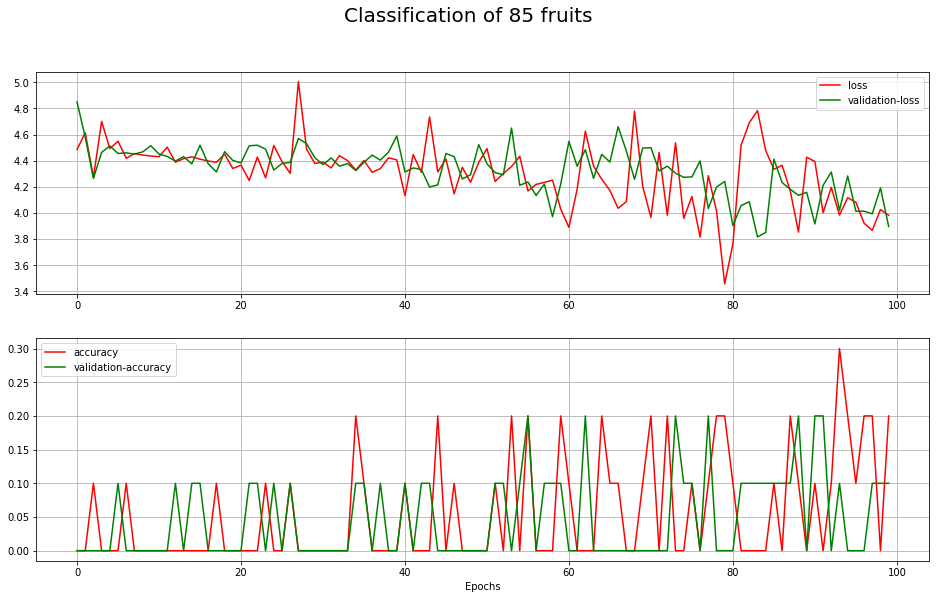

In [14]:
SMOOTH = False
epochs = history.epoch

# if SMOOTH:    
#     from scipy.interpolate import CubicSpline
#     cs_loss = CubicSpline(epochs, loss)
#     cs_acc = CubicSpline(epochs, acc)
    
#     x = np.linspace(0, epochs[-1], 100)
#     y_loss = cs_loss(x)
#     y_acc = cs_acc(x)

# else:
#     x = epochs
#     y_loss = loss
#     y_acc = acc
    
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(2,1,1)
plt.plot(loss, label='loss', c='r')
plt.plot(val_loss, label='validation-loss', c='g')
plt.legend(loc='best')
plt.grid()
plt.subplot(2,1,2)
plt.plot(accuracy, label='accuracy', c='r')
plt.plot(val_accuracy, label='validation-accuracy', c='g')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.grid()

title = f"Classification of {len(FRUITS)} fruits"
fig.suptitle(title, size=20)
pic_name = title.replace(' ', '-')
plt.savefig(f"{model_name}-graph.png")
plt.show()

In [ ]:
train_gen = BatchGen(training_path, 50)
test_gen = BatchGen(test_path, 50)
print(len(train_gen))
print(len(test_gen))
for num, (x, y) in enumerate(test_gen.get_all_batches()):
    print(num+1)